<a href="https://colab.research.google.com/github/dcolinmorgan/prediction/blob/master/working_tpu_LTRC_doge_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os,glob,gc
import pandas as pd
import numpy as np
from psutil import *
import matplotlib.pyplot as plt
from IPython.display import Image
import seaborn as sns
import math,keras,time
import tensorflow as tf
# import cupy as cp

timestr = time.strftime("%Y%m%d-%H%M")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# links=pd.read_csv('drive/My Drive/LARGE_PANDA/LARGECOPD_links.txt',names=['TF','genes'])
##CASE
# np.save('drive/My Drive/LARGE_PANDA/LARGECOPD_time_case',tdata)
# tdata=pd.DataFrame(np.load('drive/My Drive/LARGE_PANDA/LARGECOPD_time_case.npy'))
t4data=pd.DataFrame(np.load('drive/My Drive/LARGE_PANDA/LTRCcase.npy'))
t4data.columns=pd.read_csv('drive/My Drive/LARGE_PANDA/LTRCcase_ages.txt',header=None)[0]
# tdata_ages[0]
# tdata.index=pd.read_csv('drive/My Drive/LARGE_PANDA/LARGECOPD_links.txt',header=None)#[0]
# tdata=tdata.T

# #CONTROL
# # np.save('drive/My Drive/LARGE_PANDA/LARGECOPD_time_control',tdata)
# # tdata=pd.DataFrame(np.load('drive/My Drive/LARGE_PANDA/LARGECOPD_time_control.npy'))
tdata=pd.DataFrame(np.load('drive/My Drive/LARGE_PANDA/LTRCcontrol.npy'))
tdata.columns=pd.read_csv('drive/My Drive/LARGE_PANDA/LTRCcontrol_ages.txt',header=None)[0]
# # tdata_ages[0]
# tdata.index=pd.read_csv('drive/My Drive/LARGE_PANDA/LARGECOPD_links.txt',header=None)#[0]
# links=pd.read_csv('drive/My Drive/LARGE_PANDA/LARGECOPD_links.txt',header=None)#[0]
links=pd.read_csv('drive/My Drive/LARGE_PANDA/LARGECOPD_links.txt',header=None,names=['TF','gene'])


# t2data=tdata.iloc[:,0:100]
# t2data=tdata[np.abs(np.mean(tdata.iloc[:,10:20],axis=1) - np.mean(tdata.iloc[:,30:40],axis=1))>1.5]

# print(t2data.shape)
# del tdata
# tdata=pd.DataFrame()


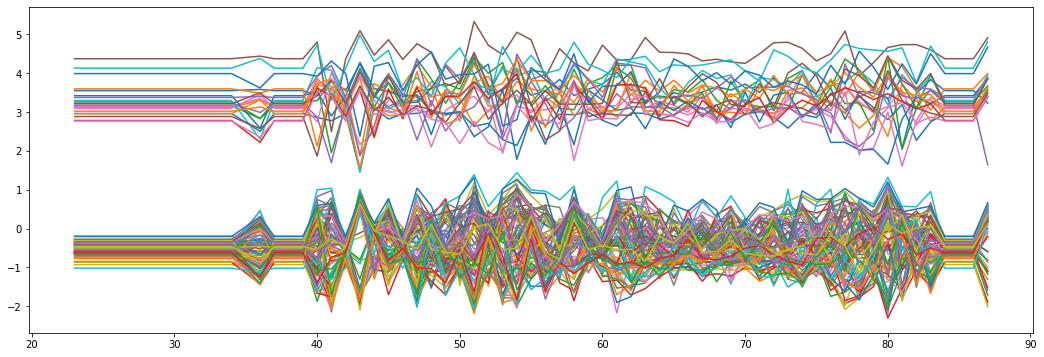

In [4]:
plt.figure(figsize=(18, 6))
w=plt.plot(tdata.T.iloc[:,1:100])

In [5]:
from scipy.stats import zscore
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from pandas.tseries.offsets import DateOffset

from keras.preprocessing import timeseries_dataset_from_array
from keras.utils import plot_model
from keras.models import load_model

from keras import Sequential
from keras.layers import Dense, LSTM, Conv1D, Bidirectional, Lambda,Dropout,Activation,RepeatVector,TimeDistributed
from keras.callbacks import EarlyStopping, LearningRateScheduler,ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.sequence import TimeseriesGenerator

In [ ]:
tf.keras.backend.clear_session()
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

strategy = tf.distribute.TPUStrategy(resolver)


##look at data first, normalize

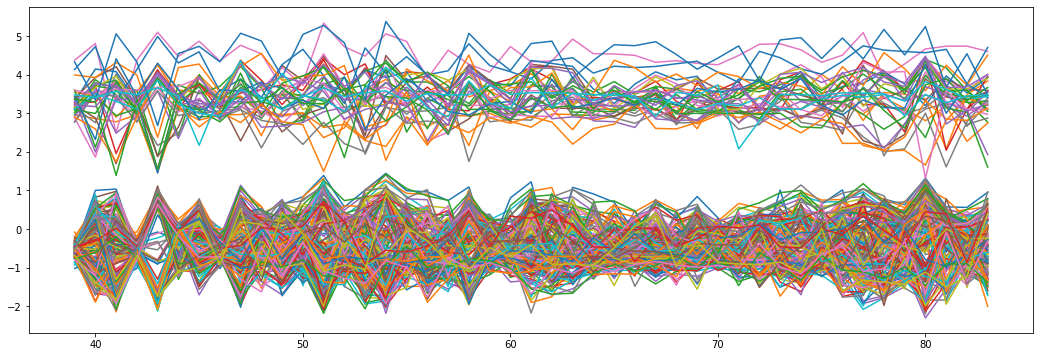

In [7]:
plt.figure(figsize=(18, 6))
w=plt.plot(tdata.T.iloc[8:53,0:200])

In [8]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))

jj=np.random.choice(range(0,len(tdata)),size=20000,replace=False)
kk=np.random.choice(range(0,len(tdata)),size=20000,replace=False)

t2data = scaler.fit_transform(tdata.T.iloc[8:53,jj])#cont_gene_sum.iloc[:,10:50])) #r2data.iloc[:,10:50]))
t3data = scaler.fit_transform(tdata.T.iloc[8:53,kk])

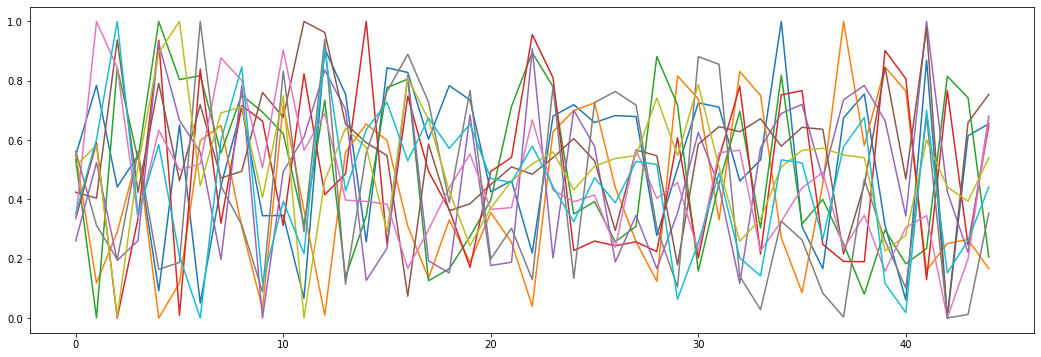

In [9]:
plt.figure(figsize=(18, 6))
w=plt.plot(pd.DataFrame(t2data).iloc[:,0:10])

In [10]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))

jj=np.random.choice(range(0,len(t4data)),size=20000,replace=False)
kk=np.random.choice(range(0,len(t4data)),size=20000,replace=False)

t5data = scaler.fit_transform(t4data.T.iloc[8:53,jj])#cont_gene_sum.iloc[:,10:50])) #r2data.iloc[:,10:50]))
t6data = scaler.fit_transform(t4data.T.iloc[8:53,kk])

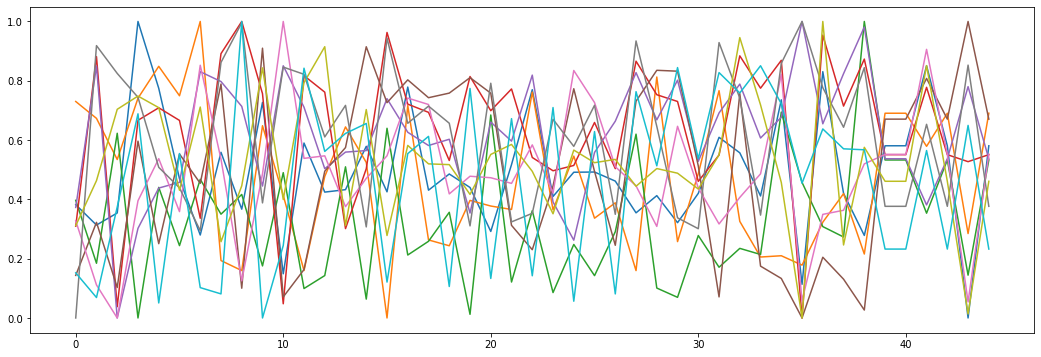

In [11]:
plt.figure(figsize=(18, 6))
w=plt.plot(pd.DataFrame(t5data).iloc[:,0:10])

## begin reworked model

[tutorial here](https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/)

In [12]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)


In [13]:
dataset=t2data[:,0:200]

# choose a number of time steps
n_steps_in, n_steps_out = 40, 5
# covert into input/output
X, y = split_sequences(dataset, n_steps_in, n_steps_out)
print([X.shape,y.shape])
# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]


[(1, 40, 200), (1, 5, 200)]


In [14]:
dataset=t5data[:,0:200]

# choose a number of time steps
n_steps_in, n_steps_out = 40, 5
# covert into input/output
X1, y1 = split_sequences(dataset, n_steps_in, n_steps_out)
print([X1.shape,y1.shape])
# the dataset knows the number of features, e.g. 2
n_features = X1.shape[2]

# strategy = tf.distribute.TPUStrategy(resolver)


[(1, 40, 200), (1, 5, 200)]


In [15]:
# define model (original)

with strategy.scope():
  model = Sequential()
  model.add(LSTM(2000, activation='relu', input_shape=(n_steps_in, n_features)))
  model.add(RepeatVector(n_steps_out))
  model.add((LSTM(2000,activation='relu',return_sequences=True)))
  # model.add(Bidirectional(LSTM(2000,activation='relu',return_sequences=True)))
  # model.add((LSTM(2000,activation='relu',return_sequences=True)))
  # model.add(Bidirectional(LSTM(2000,activation='relu',return_sequences=True)))
  # model.add((LSTM(2000,activation='relu',return_sequences=True)))

  # model.add((LSTM(2000,activation='relu',return_sequences=True))),
  # model.add(Activation('relu'))
  # model.add((LSTM(1024,activation='relu',return_sequences=True))),
  # model.add((LSTM(1024,activation='relu',return_sequences=True))),
  # model.add(LSTM(512, activation='relu', return_sequences=True))
  model.add(TimeDistributed(Dense(n_features)))
  model.compile(optimizer='adam', loss='mse')
  print(model.summary())


  

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 2000)              17608000  
_________________________________________________________________
repeat_vector (RepeatVector) (None, 5, 2000)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 5, 2000)           32008000  
_________________________________________________________________
time_distributed (TimeDistri (None, 5, 200)            400200    
Total params: 50,016,200
Trainable params: 50,016,200
Non-trainable params: 0
_________________________________________________________________
None


In [16]:
history = model.fit(X, y, epochs=150)#,verbose=0) ## swap training with X for X1 and back

model.save('~/drive/MyDrive/LARGE_PANDA/model_output/case_420_tutorial_model_'+timestr+'.h5')
# plot_model(model, to_file='drive/MyDrive/LARGE_PANDA/model_output/420_tutorial_model_'+timestr+'.png', show_shapes=True)
# Image(filename='drive/MyDrive/LARGE_PANDA/model_output/420_tutorial_model_'+timestr+'.png')


Epoch 1/150
1/1 [==============================] - 9s 9s/step - loss: 0.3289
Epoch 2/150
1/1 [==============================] - 0s 104ms/step - loss: 0.1945
Epoch 3/150
1/1 [==============================] - 0s 108ms/step - loss: 11744099328.0000
Epoch 4/150
1/1 [==============================] - 0s 106ms/step - loss: 73483962810368.0000
Epoch 5/150
1/1 [==============================] - 0s 103ms/step - loss: 337306871499063296.0000
Epoch 6/150
1/1 [==============================] - 0s 106ms/step - loss: 513101463472308224.0000
Epoch 7/150
1/1 [==============================] - 0s 104ms/step - loss: 23724246144385024.0000
Epoch 8/150
1/1 [==============================] - 0s 106ms/step - loss: 9195584036536320.0000
Epoch 9/150
1/1 [==============================] - 0s 105ms/step - loss: 8132864172359680.0000
Epoch 10/150
1/1 [==============================] - 0s 107ms/step - loss: 9497171271352320.0000
Epoch 11/150
1/1 [==============================] - 0s 103ms/step - loss: 2316272373

In [17]:
from keras.models import load_model
# model = load_model('/content/drive/MyDrive/LARGE_PANDA/model_output/Cont_geneoutdegree_20210414-2043.h')
model = load_model('~/drive/MyDrive/LARGE_PANDA/model_output/case_420_tutorial_model_'+timestr+'.h5')
# model=load_model('/content/drive/MyDrive/LARGE_PANDA/model_output/420_tutorial_model_20210421-1655.h5')
model.compile(loss='mse',
              experimental_steps_per_execution = 50,
              optimizer='adam',
              metrics=['mse'])

### expanded model

In [ ]:
## swap in this model
model = Sequential()
## graph neural network then (lower D space) to LSTM (neighborhood) NOT conv1d (spatial from images)
initializer=tf.keras.initializers.Orthogonal()
model.add(LSTM(1024, input_shape=(n_steps_in, n_features), kernel_initializer=initializer)) #orthoganal initialization for weight, he  # 5 time steps and 32831 features/genes
# model.add(Activation('relu'))
model.add(RepeatVector(n_steps_out))
model.add(Bidirectional(LSTM(512,activation='relu',return_sequences=True))),
model.add((LSTM(512,activation='relu',return_sequences=True))),
model.add((LSTM(512,activation='relu',return_sequences=True))),
# model.add(RepeatVector(n_steps_out))
model.add((LSTM(512,activation='relu',return_sequences=True))),
model.add((LSTM(512,activation='relu',return_sequences=True))),
model.add(Bidirectional(LSTM(512,activation='relu',return_sequences=True))),
# model.add(Activation('relu'))
model.add(Bidirectional(LSTM(256,activation='relu',return_sequences=True))),
model.add((LSTM(256,activation='relu',return_sequences=True))),
model.add((LSTM(256,activation='relu',return_sequences=True))),
model.add((LSTM(256,activation='relu',return_sequences=True))),
model.add((LSTM(256,activation='relu',return_sequences=True))),

# model.add(Bidirectional(LSTM(128,activation='relu',return_sequences=True))),
model.add((LSTM(128,activation='relu',return_sequences=True))),

model.add(LSTM(64,activation='relu', return_sequences=True))
# model.add(Dropout(0.15))
# model.add((LSTM(32,activation='relu'))),
# model.add(Dense(training_sequence.data.shape[1]))
model.add(TimeDistributed(Dense(n_features)))


model.compile(loss='mse',
              experimental_steps_per_execution = 50,
              optimizer='adam',
              metrics=['mse'])
# print(model.summary())


In [ ]:
callbacks = [
    LearningRateScheduler(lambda epoch: 1e-6 * 10**(epoch / 20)),
    EarlyStopping(patience=5, verbose=1),#monitor='loss'),
    # ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model.h5', verbose=1, save_best_only=True, save_weights_only=False)
]

NameError: ignored

In [ ]:
# tf.config.run_functions_eagerly(False) ## steps per epoch are total time steps / look_back, ie 40 year / 5 lookback
# history = model.fit(training_sequence, epochs=100, callbacks=callbacks,validation_data=validation_sequence)


# history = model.fit(X, validation_data=y, epochs=300, verbose=0,callbacks=callbacks)



In [ ]:
# model.save('drive/MyDrive/LARGE_PANDA/model_output/420_new_model_'+timestr+'.h')
# plot_model(model, to_file='drive/MyDrive/LARGE_PANDA/model_output/420_new_model_'+timestr+'.png', show_shapes=True)
# Image(filename='drive/MyDrive/LARGE_PANDA/model_output/420_new_model_'+timestr+'.png')
# from keras.models import load_model
# # model = load_model('/content/drive/MyDrive/LARGE_PANDA/model_output/Cont_geneoutdegree_20210414-2043.h')
# model = load_model('/content/drive/MyDrive/LARGE_PANDA/model_output/420_new_model_'+timestr+'.h')
# model.compile(loss='mse',
#               experimental_steps_per_execution = 50,
#               optimizer='adam',
#               metrics=['mse'])

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

plt.figure(figsize=(18, 8))
plt.plot(hist['epoch'],hist['val_loss'], color= 'green')
# plt.plot(loss, color='red')
# plt.title("Close price of stocks sold")
plt.xlabel("EPOCH")
plt.ylabel("VAL_LOSS")
plt.show()

### predict

In [29]:
jeff=np.random.randint(99)
print(jeff)
x_input = np.expand_dims(t2data[0:40,dataset.shape[1]*jeff:dataset.shape[1]*(jeff+1)],axis=0) ## take random batch of 200 control links
yhat = model.predict(x_input, verbose=0)

x1_input = np.expand_dims(t5data[0:40,dataset.shape[1]*jeff:dataset.shape[1]*(jeff+1)],axis=0) ## take random batch of 200 case links
y1hat = model.predict(x1_input, verbose=0)


48


In [30]:
[X.shape,y.shape,yhat.shape]

[(1, 40, 200), (1, 5, 200), (1, 5, 200)]

In [31]:
trainScore = math.sqrt(mean_squared_error(y[0], yhat[0]))
print('Train Score: %.2f RMSE' % (trainScore))

Train Score: 0.06 RMSE


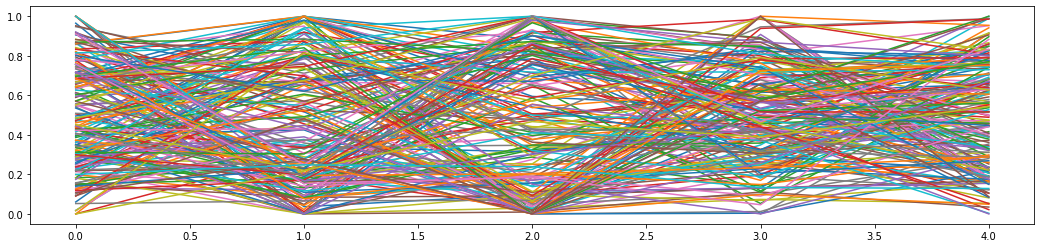

In [32]:
plt.figure(figsize=(18, 4))
c=plt.plot(y[0])

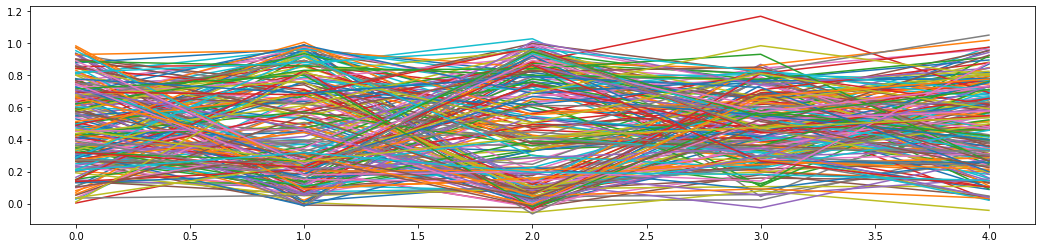

In [33]:
plt.figure(figsize=(18, 4))
c=plt.plot(yhat[0])

In [34]:
t2data[0:40,200:400].shape

(40, 200)

In [35]:
trainScore = math.sqrt(mean_squared_error(y1[0], y1hat[0]))
print('Train Score: %.2f RMSE' % (trainScore))

Train Score: 0.42 RMSE


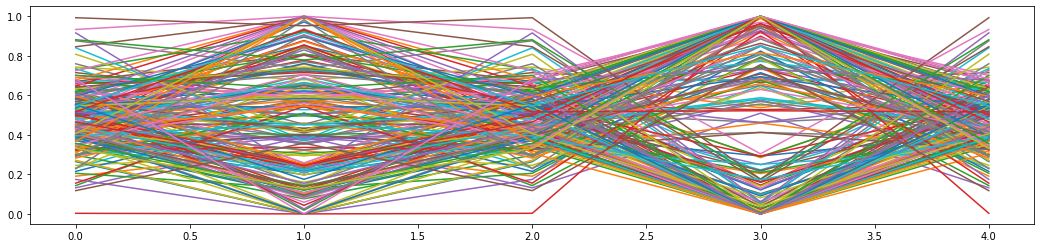

In [36]:
plt.figure(figsize=(18, 4))
c=plt.plot(y1[0])

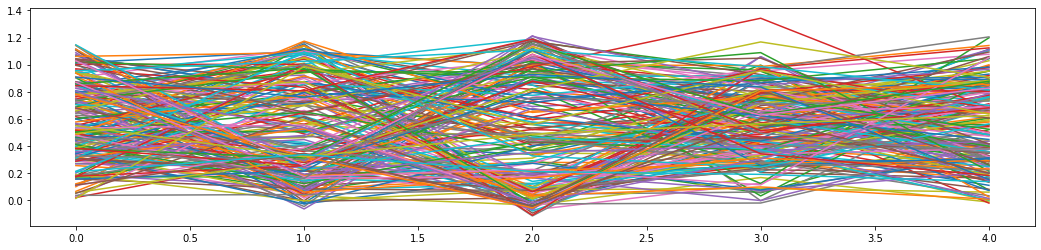

In [37]:
plt.figure(figsize=(18, 4))
c=plt.plot(y1hat[0])